In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
import healpy as hp

In [18]:
# Reading in data and assigning it to variables even though Greg seems to think it's a waste of time.

# Read in data
hdulist = fits.open('http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/external/survey-dr3-specObj-dr13.fits') # survey
hdulist2 = fits.open('https://data.sdss.org/sas/dr13/sdss/spectro/redux/specObj-dr13.fits')
tbdata = hdulist[1].data
tbdata2 = hdulist2[1].data

# Put data in arrays

# Object ID from survey file; value -1 for non-matches
objid = []
objid = tbdata.field('OBJID') 

# Only galaxies included
gal_type = []
gal_type = tbdata.field('TYPE') 

# RA
ra = []
ra = tbdata.field('RA')

# Dec
dec = []
dec = tbdata.field('DEC')

# Array for LOWZ targets
targets = []
targets = tbdata2.field('BOSS_TARGET1')

# Section of code to find LRG targets

def divideBy2(decNumber):

	# from pythonds.basic.stack import Stack
# 	import numpy as np

	np.vectorize(decNumber)  
	remstack = Stack()
	
	if decNumber == 0: return "0"
	
	while decNumber > 0:
		rem = decNumber % 2
		remstack.push(rem)
		decNumber = decNumber // 2
		
	binString = ""
	while not remstack.isEmpty():
		binString = binString + str(remstack.pop())
			
	return binString
	
	
	
# Function to find LOWZ targets
divideBy2Vec = np.vectorize(divideBy2)

a = divideBy2Vec(targets) # gives binary in string form

b = []
c = []

for i in range(len(a)):
	b.append(list((a[i])))
	b[i].reverse()
	
# print(b)

lrg = []

# Finds flags for BOSS LOWZ and CMASS sample
for i in range(len(b)):
	try:
		if (b[i][0] == '1') or (b[i][1] == '1'):
			lrg.append(int(1))
		else:
			lrg.append(int(0))
	except IndexError:
		pass
# 		print('pass statement')
		lrg.append(int(0))
		
lrg = np.array(lrg)

# Class of object
gal_class = []
gal_class = tbdata2.field('CLASS')

# What survey the data is from
survey = []
survey = tbdata2.field('SURVEY')

# SPECPRIMARY; set to 1 for primary observation of object, 0 otherwise
spec = []
spec = tbdata2.field('SPECPRIMARY')

# Bitmask of spectroscopic warning values; need set to 0
zwarn_noqso = []
zwarn_noqso = tbdata2.field('ZWARNING_NOQSO')

# Spectroscopic classification for certain redshift?
class_noqso = []
class_noqso = tbdata2.field('CLASS_NOQSO')

# LOWZ_cut = ((objid > -1) & (tar == 1) & ((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))
LOWZ_cut = ((objid > -1) & (lrg == 1) & ((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))
# print(len(LOWZ_cut))

# Cut excludes LRGs
# no_LOWZ_cut = ((tar == 0) & ((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5))
no_LOWZ_cut = ((lrg == 0) & ((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5))

# Number of observations of source from legacy file
# Not cut for LOWZ
obs = []
obsmatch = []
obs = tbdata.field('DECAM_NOBS') 
obsmatch = obs[np.where(no_LOWZ_cut)] 
print(len(obsmatch))

# Put number of observations per filter into arrays that match the filter
uobs = []
gobs = []
robs = []
iobs = []
zobs = []
yobs = []

b = np.array(obsmatch)
uobs = b[:,0]
gobs = b[:,1]
robs = b[:,2]
iobs = b[:,3]
zobs = b[:,4]
yobs = b[:,5]

# Put flux data in an array from legacy file
# Flux has ugrizY, so needs to be divided into 6 arrays
flux =[]
fluxmatch = []

# Flux from DECAM
# cuts LRGs
flux = tbdata.field('DECAM_FLUX')
fluxmatch = flux[np.where(no_LOWZ_cut)]

# Divide flux arrays into 6 arrays
uflux = []
gflux = []
rflux = []
iflux = []
zflux = []
yflux = []

a = np.array(fluxmatch)
uflux = a[:,0]
gflux = a[:,1]
rflux = a[:,2]
iflux = a[:,3]
zflux = a[:,4]
yflux = a[:,5]


# Redshift of galaxies according to sdss
redshift = []
redshift = tbdata2.field('Z') 

# Number of observations for LOWZ targets
obs_LOWZ = obs[np.where(LOWZ_cut)]
print(len(obs_LOWZ))
    
obs_LOWZ_array = np.array(obs_LOWZ)
uobs_LOWZ = obs_LOWZ_array[:,0]
gobs_LOWZ = obs_LOWZ_array[:,1]
robs_LOWZ = obs_LOWZ_array[:,2]
iobs_LOWZ = obs_LOWZ_array[:,3]
zobs_LOWZ = obs_LOWZ_array[:,4]
yobs_LOWZ = obs_LOWZ_array[:,5]

# Flux for LOWZ targets
flux_LOWZ = flux[np.where(LOWZ_cut)]

flux_LOWZ_array = np.array(flux_LOWZ)
uflux_LOWZ = flux_LOWZ_array[:,0]
gflux_LOWZ = flux_LOWZ_array[:,1]
rflux_LOWZ = flux_LOWZ_array[:,2]
iflux_LOWZ = flux_LOWZ_array[:,3]
zflux_LOWZ = flux_LOWZ_array[:,4]
yflux_LOWZ = flux_LOWZ_array[:,5]


2375
2074


Excludes LRGs
length of gmag array =  1832
length of rmag array =  1832
length of color array =  1832
Max gmag =  28.7781
Min gmag =  14.4911
Max rmag =  24.3972
Min rmag =  13.674
Min color =  -0.656357
Max color =  8.97626

Only LRG sources
length of gmag array =  1614
length of rmag array =  1614
length of color array =  1614
Max gmag =  25.1832
Min gmag =  17.0737
Max rmag =  22.3639
Min rmag =  15.8399
Min color =  -0.201712
Max color =  3.04881

Only LRGs
Max z =  0.846769
Min z =  0.0721669


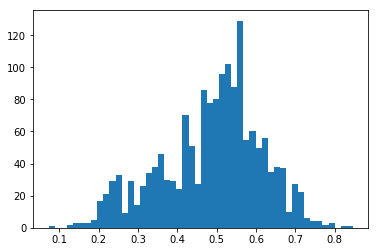

In [21]:
# Calculates gmag, rmag, and color for every galaxy in EDR

# Finds the flux in the g and r band that have at least 3 obervations in each with the flux in each > 0, calculates
# the magnitude in g and r, and calculates the (g-r) color

# Excludes LRGS
# Finds flux that correspond with at least 3 observations and a flux > 0
gflux_match = gflux[np.where((gobs >= 3.) & (robs >= 3.) & (gflux > 0.) & (rflux > 0.))]
rflux_match = rflux[np.where((gobs >= 3.) & (robs >= 3.) & (rflux > 0.) & (gflux > 0.))]

gmag = 22.5 - 2.5 * np.log10(gflux_match)
rmag = 22.5 - 2.5 * np.log10(rflux_match)

color = gmag - rmag

print("Excludes LRGs")
print("length of gmag array = ", len(gmag))
print("length of rmag array = ",len(rmag))
print("length of color array = ", len(color))
print("Max gmag = ", np.amax(gmag))
print("Min gmag = ", np.amin(gmag))
print("Max rmag = ", np.amax(rmag))
print("Min rmag = ", np.amin(rmag))
print("Min color = ", np.amin(color))
print("Max color = ", np.amax(color))

# Only LRGs
gflux_match_LOWZ = gflux_LOWZ[np.where((gobs_LOWZ >= 3.) & (robs_LOWZ >= 3.) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]
rflux_match_LOWZ = rflux_LOWZ[np.where((gobs_LOWZ >= 3.) & (robs_LOWZ >= 3.) & (rflux_LOWZ > 0.) & (gflux_LOWZ > 0.))]

gmag_LOWZ = 22.5 - 2.5 * np.log10(gflux_match_LOWZ)
rmag_LOWZ = 22.5 - 2.5 * np.log10(rflux_match_LOWZ)

color_LOWZ = gmag_LOWZ - rmag_LOWZ

print("")
print("Only LRG sources")
print("length of gmag array = ", len(gmag_LOWZ))
print("length of rmag array = ",len(rmag_LOWZ))
print("length of color array = ", len(color_LOWZ))
print("Max gmag = ", np.amax(gmag_LOWZ))
print("Min gmag = ", np.amin(gmag_LOWZ))
print("Max rmag = ", np.amax(rmag_LOWZ))
print("Min rmag = ", np.amin(rmag_LOWZ))
print("Min color = ", np.amin(color_LOWZ))
print("Max color = ", np.amax(color_LOWZ))

# Redshift values
redshift_cut = redshift[np.where(LOWZ_cut)]
z = redshift_cut[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]

# Only LRGs
print("")
print("Only LRGs")
print("Max z = ", np.amax(z))
print("Min z = ", np.amin(z))

plt.hist(z, bins = 50)
plt.show()

In [22]:
# cosmoCalc function to find scale (kpc_DA)
# This is a modified Python Code for this cosmological calculator (http://www.astro.ucla.edu/~wright/CC.python),
# Which is in turn modified from http: http://www.astro.ucla.edu/~wright/CosmoCalc.html. 

# I know this isn't ideal but for some reason the function won't import, even though it imports just fine in other
# files in the same directory

def cosmoCalcfunc(z):
    import numpy as np
    from math import sqrt
    from math import exp
    from math import sin
    from math import pi

# Calculate scale to get areas
    H0 = 69.6
    WM = 0.286
    WV = 0.714
# z = 0.209855

# initialize constants

    WR = 0.        # Omega(radiation)
    WK = 0.        # Omega curvaturve = 1-Omega(total)
    c = 299792.458 # velocity of light in km/sec
    Tyr = 977.8    # coefficent for converting 1/H into Gyr
    DTT = 0.5      # time from z to now in units of 1/H0
    DTT_Gyr = []  # value of DTT in Gyr
    age = 0.5      # age of Universe in units of 1/H0
    age_Gyr = []  # value of age in Gyr
    zage = 0.1     # age of Universe at redshift z in units of 1/H0
    zage_Gyr = [] # value of zage in Gyr
    DCMR = 0.0     # comoving radial distance in units of c/H0
    DCMR_Mpc = [] 
    DCMR_Gyr = []
    DA = 0.0       # angular size distance
    DA_Mpc = []
    DA_Gyr = []
    kpc_DA = []
    DL = 0.0       # luminosity distance
    DL_Mpc = []
    DL_Gyr = []   # DL in units of billions of light years
    V_Gpc = []
    a = 1.0        # 1/(1+z), the scale factor of the Universe
    az = 0.5       # 1/(1+z(object))

    h = H0/100.
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV

    for j in range(len(z)):
        az = 1.0/(1+1.0*z[j])
        age = 0.
        n=1000         # number of points in integrals
        for i in range(n):
            a = az*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            age = age + 1./adot

        zage = az*age/n
        zage_Gyr.append((Tyr/H0)*zage)
        DTT = 0.0
        DCMR = 0.0

	# do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
        for i in range(n):
            a = az+(1-az)*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            DTT = DTT + 1./adot
            DCMR = DCMR + 1./(a*adot)

        DTT = (1.-az)*DTT/n
        DCMR = (1.-az)*DCMR/n
        age = DTT+zage
        age_Gyr.append(age*(Tyr/H0))
        DTT_Gyr.append((Tyr/H0)*DTT)
        DCMR_Gyr.append((Tyr/H0)*DCMR)
        DCMR_Mpc.append((c/H0)*DCMR)

	# tangential comoving distance

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio =  0.5*(exp(x)-exp(-x))/x 
            else:
                ratio = sin(x)/x
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/6. + y*y/120.
        DCMT = ratio*DCMR
        DA = az*DCMT
        DA_Mpc.append((c/H0)*DA)
        kpc_DA.append(DA_Mpc[j]/206.264806)
        DA_Gyr.append((Tyr/H0)*DA)
        DL = DA/(az*az)
        DL_Mpc.append((c/H0)*DL)
        DL_Gyr.append((Tyr/H0)*DL)

	# comoving volume computation

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio = (0.125*(exp(2.*x)-exp(-2.*x))-x/2.)/(x*x*x/3.)
            else:
                ratio = (x/2. - sin(2.*x)/4.)/(x*x*x/3.)
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/5. + (2./105.)*y*y
        VCM = ratio*DCMR*DCMR*DCMR/3.
        V_Gpc.append(4.*pi*((0.001*c/H0)**3)*VCM)
        
    return(DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc)

DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z)

H:
[[   0.   12.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.   46.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  233.   12.    0.    0.    0.    0.    0.    0.    0.]
 [   5.  813.  205.    0.    0.    0.    0.    0.    0.    0.]
 [   1.   46.  224.    0.    0.    0.    0.    0.    0.    0.]
 [   4.   15.   88.    0.    0.    0.    0.    0.    0.    1.]
 [   3.   20.   95.    1.    0.    0.    0.    0.    0.    0.]
 [   1.    1.    3.    0.    0.    0.    0.    0.    0.    0.]
 [   1.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   1.    1.    0.    0.    0.    0.    0.    0.    0.    0.]]
-------
shape H
(10, 10)
sd:
[[  0.00000000e+00   3.70370370e-08   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.41975309e-07   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00  

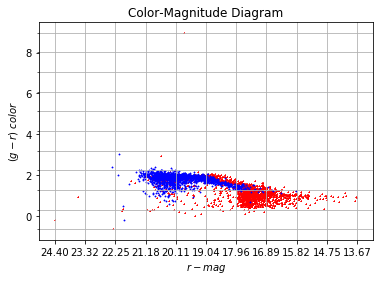

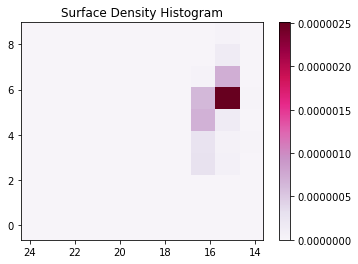

In [48]:
# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin. H is the matrix 
# with the number of points per bin. Uses this number to calculate the surface density, by dividing the number
# of sources per bin by the area of the EDR. (This is done for every bin.)

# Histogram in color-magnitude space

# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin
# H is the matrix with the number of points per bin
# xedges, yedges are the bounds of the bins
row = 10
column = 10
# creates histogram for survey sources; excluses LRGs
H, xedges, yedges = np.histogram2d(rmag, color, normed=False)
print("H:")
print(H)
print('-------')
print('shape H')
print(np.shape(H))

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of sources
# divided by the area 
sd = H/(25. * (3600.**2.)) # converts 25 square degrees to square arcseconds
print("sd:")
print(sd)
print('-------')

# Scatter plot of points with bin lines drawn
fig, ax = plt.subplots()
ax.set_xticks(xedges, minor=False)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

# plt.scatter(rmag, color, s = 1, marker = '+', color='red')
# plt.scatter(rmag_LOWZ, color_LOWZ, s = 1, marker = '*', color='blue')
# plt.gca().invert_xaxis()
# plt.title("Color-Magnitude Diagram")
# plt.xlabel(r'$r-mag$')
# plt.ylabel(r'$(g-r)$ $color$')
# plt.show()

# color codes bins by surface density with color bar; should make sense when compared to scatter plot
plt.imshow(sd, cmap=plt.cm.PuRd, extent=(xedges[0], xedges[len(xedges)-1], yedges[0], yedges[len(yedges)-1]))
plt.colorbar(orientation='vertical')
plt.gca().invert_xaxis()
plt.title("Surface Density Histogram")
plt.show()

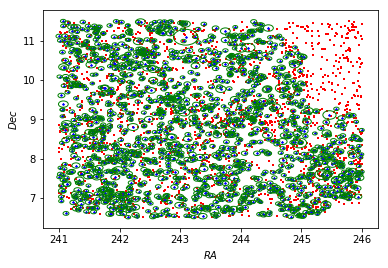

In [24]:
# Counting NEAR NEIGHBORS (nn) using KDTree
# Result is an array of the number of near neighbors each LRG has

ra_LOWZ0 = ra[np.where(LOWZ_cut)]
ra_LOWZ = ra_LOWZ0[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]
dec_LOWZ0 = dec[np.where(LOWZ_cut)]
dec_LOWZ = dec_LOWZ0[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]

ra_no_LOWZ0 = ra[np.where(no_LOWZ_cut)]
ra_no_LOWZ = ra_no_LOWZ0[np.where((gobs >= 3) & (robs >= 3) & (gflux > 0.) & (rflux > 0.))]
dec_no_LOWZ0 = dec[np.where(no_LOWZ_cut)]
dec_no_LOWZ = dec_no_LOWZ0[np.where((gobs >= 3) & (robs >= 3) & (gflux > 0.) & (rflux > 0.))]


# Distance from which we are looking for satellites around the LRGs
distance = 1. # in Mpc
distance_kpc = distance * 10.**3. # in kpc

dist = []
for i in range(len(kpc_DA)):
    dist.append((distance_kpc / kpc_DA[i]) * 1./3600.) 

# Plot RA/Dec plot with circles around LRGs
# Plots LRG sources and EDR sources
plt.scatter(ra_no_LOWZ, dec_no_LOWZ, s = 3, marker = '+', color='red')
plt.scatter(ra_LOWZ, dec_LOWZ, s = 3, marker = '*', color='blue')

# Draws circle of some radius around the LRG sources
# Circles too small to really see in the plot, but I have tested it with bigger radii to make sure it works if I
# ever need it.
circle = []
for i in range(len(ra_LOWZ)):
    circle = plt.Circle((ra_LOWZ[i],dec_LOWZ[i]), dist[i], color='green', fill=False)
    plt.gcf().gca().add_artist(circle)

plt.xlabel(r'$RA$')
plt.ylabel(r'$Dec$')
plt.show()

# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_lrg = list(zip(ra_LOWZ, dec_LOWZ)) # Fake LRG sources
zip_list_survey = list(zip(ra_no_LOWZ, dec_no_LOWZ)) # Fake EDR sources

# Creates a tree of EDR sources
gal_tree = KDTree(zip_list_survey)

# returns a list of EDR sources that are within some radius r of an LRG
nn = gal_tree.query_radius(zip_list_lrg,r=dist,count_only=True)

# find indices of near neighbors
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
ind = gal_tree.query_radius(zip_list_lrg,r=dist)
# print(ind)
# print(type(ind[5]))
# ind5 = ind[0]
# print(ind5)
# print(type(ind5[0]))

# Creates one list of number of near neighbors for every LRG (number of lists = number of LRGs)
# NEAR is the list of 2D arrays of satellite galaxies as a funciton of color and magnitude
near = []

for i in range(len(ind)):
    # Creates a zero array if there are no near neighbors
    if len(ind[i]) == 0:
        hist2d = np.zeros((len(xedges)-1,len(yedges)-1))
        near.append(hist2d)
    # Creates a 2D histogram for satellite galaxies
    else:
        hist2d, x_notuse, y_notuse = np.histogram2d(rmag[ind[i]], color[ind[i]], bins=(xedges, yedges), normed=False)
        near.append(hist2d)


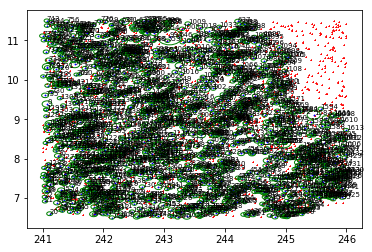

In [25]:
# Calculates NUMBER OF EXPECTED INTERLOPER GALAXIES (Nbkg) by first calculating the solid angle omega enclosed in 
# radius distance_kpc from the LRG. Then find the number of interloper galaxies by multiplying omega by the surface 
# density to find the number of interloper galaxies as a function of color and magnitude.

# Calculate solid angle omega for every radius ()
omega = []

for i in range(len(kpc_DA)):
    omega.append((np.pi * distance_kpc**2.)/(kpc_DA[i])**2.) # in square arcsec

# Multiply omega by the surface density
Nbkg = []

for i in range(len(omega)):
    Nbkg.append(sd * omega[i])
    
# Plots LRG sources and EDR sources
plt.scatter(ra_no_LOWZ, dec_no_LOWZ, s = 1, marker = '+', color='red')
plt.scatter(ra_LOWZ, dec_LOWZ, s = 1, marker = '*', color='blue')

# Plots circles around LRG sources 
circle = []
for i in range(len(ra_LOWZ)):
    circle = plt.Circle((ra_LOWZ[i],dec_LOWZ[i]), dist[i], color='green', fill=False)
    plt.gcf().gca().add_artist(circle)
    
# prints ID numbers next to LRG
# This will be slightly different when using real data because those sources have real ID numbers
a = np.arange(0,len(ra_LOWZ))
for i, txt in enumerate(a):
    text = plt.annotate(txt, (ra_LOWZ[i],dec_LOWZ[i]))
    text.set_fontsize(7)

plt.show()


In [26]:
# Calculate NUMBER OF SATELLITE GALAXIES (Nsat) by subtracting interloper galaxies from near neighbor galaxies as a 
# function of color and magnitude.

Nsat = np.array(near) - np.array(Nbkg)
print(len(Nsat))

1614


mean near neighbor is 0.645600991326
standard deviation of near neighbor is 1.00348950247
mean interloper is 0.569040469509
standard deviation of interloper is 0.374078252915
mean number of satellites is 0.0765605218172
standard deviation of satellites is 0.910873852316


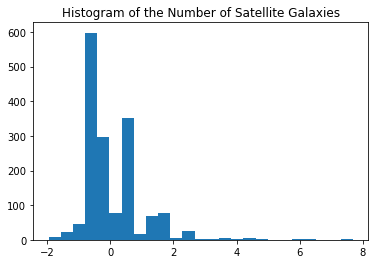

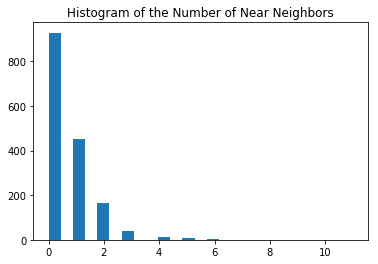

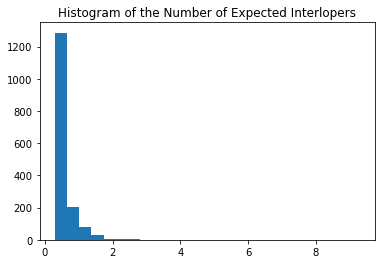

In [27]:
# Sum up satellite galaxies, expected interloper galaxies, and near neighbors
# Produce LaTeX code for a table with columns for projected radius, near neighbors, number of interlopers, number of
# satellite galaxies

sumsat = []
sumbkg = []
sumnear = []

for i in range(len(Nsat)):
    sumsat.append(np.sum(Nsat[i]))

for i in range(len(Nbkg)):
    sumbkg.append(np.sum(Nbkg[i]))
    
for i in range(len(near)):
    sumnear.append(np.sum(near[i]))

# d = {'projected radius': dist, 'number of near neighbors': nn, 'number of interlopers': sumbkg, 'number of satellites': sumsat}

# df = pd.DataFrame(data=d)

# print(tabulate(df, headers='keys', tablefmt='latex'))

meannear = np.mean(sumnear)
print("mean near neighbor is", meannear)

sdnear = np.std(sumnear)
print("standard deviation of near neighbor is", sdnear)

meanbkg = np.mean(sumbkg)
print("mean interloper is", meanbkg)

sdbkg = np.std(sumbkg)
print("standard deviation of interloper is", sdbkg)

meansat = np.mean(sumsat)
print("mean number of satellites is", meansat)

sdsat = np.std(sumsat)
print("standard deviation of satellites is", sdsat)

plt.title("Histogram of the Number of Satellite Galaxies")
plt.hist(sumsat, bins=25)
plt.show()

plt.title("Histogram of the Number of Near Neighbors")
plt.hist(sumnear, bins=25)
plt.show()


plt.title("Histogram of the Number of Expected Interlopers")
plt.hist(sumbkg, bins=25)
plt.show()

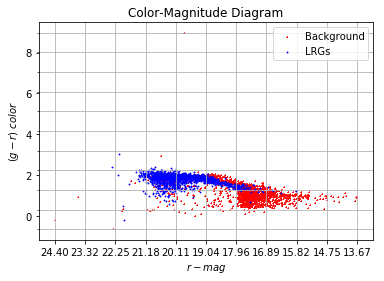

In [50]:
# CMD

fig, ax = plt.subplots()
ax.set_xticks(xedges, minor=False)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

plt.scatter(rmag, color, s = 1, marker = '+', color='red', label="Background")
plt.scatter(rmag_LOWZ, color_LOWZ, s = 1, marker = '*', color='blue', label='LRGs')
plt.gca().invert_xaxis()
plt.title("Color-Magnitude Diagram")
plt.xlabel(r'$r-mag$')
plt.ylabel(r'$(g-r)$ $color$')
plt.legend(loc='upper right')
plt.show()

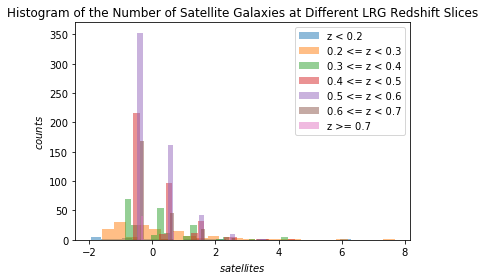

In [34]:
# Plot distribution of Nsat in different LRG redshift bins

z = np.array(z)
# print("z = ", z)
# print(type(z))

# LRG redshift from 0.0721669 <= z <= 0.846769
# bins of ~0.1

# z < 0.2
Nsat1z = Nsat[np.where(z < 0.2)]
# print(len(Nsat1))

sumsat1z = []
for i in range(len(Nsat1z)):
    sumsat1z.append(np.sum(Nsat1z[i]))

# 0.2 <= z < 0.3
Nsat2z = Nsat[np.where((z >= 0.2) & (0.3 > z))]
# print(len(Nsat2))

sumsat2z = []
for i in range(len(Nsat2z)):
    sumsat2z.append(np.sum(Nsat2z[i]))

# 0.3 <= z < 0.4
Nsat3z = Nsat[np.where((z >= 0.3) & (0.4 > z))]
# print(len(Nsat3))

sumsat3z = []
for i in range(len(Nsat3z)):
    sumsat3z.append(np.sum(Nsat3z[i]))

# 0.4 <= z < 0.5
Nsat4z = Nsat[np.where((z >= 0.4) & (0.5 > z))]
# print(len(Nsat4))

sumsat4z = []
for i in range(len(Nsat4z)):
    sumsat4z.append(np.sum(Nsat4z[i]))

# 0.5 <= z < 0.6
Nsat5z = Nsat[np.where((z >= 0.5) & (0.6 > z))]
# print(len(Nsat5))

sumsat5z = []
for i in range(len(Nsat5z)):
    sumsat5z.append(np.sum(Nsat5z[i]))

# 0.6 <= z < 0.7
Nsat6z = Nsat[np.where((z >= 0.6) & (0.7 > z))]
# print(len(Nsat6))

sumsat6z = []
for i in range(len(Nsat6z)):
    sumsat6z.append(np.sum(Nsat6z[i]))

# z >= 0.7
Nsat7z = Nsat[np.where(z >= 0.7)]
# print(len(Nsat7))

sumsat7z = []
for i in range(len(Nsat7z)):
    sumsat7z.append(np.sum(Nsat7z[i]))

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG Redshift Slices")
plt.hist(sumsat1z, bins=25, alpha=0.5, label='z < 0.2')
plt.hist(sumsat2z, bins=25, alpha=0.5, label='0.2 <= z < 0.3')
plt.hist(sumsat3z, bins=25, alpha=0.5, label='0.3 <= z < 0.4')
plt.hist(sumsat4z, bins=25, alpha=0.5, label='0.4 <= z < 0.5')
plt.hist(sumsat5z, bins=25, alpha=0.5, label='0.5 <= z < 0.6')
plt.hist(sumsat6z, bins=25, alpha=0.5, label='0.6 <= z < 0.7')
plt.hist(sumsat7z, bins=25, alpha=0.5, label='z >= 0.7')
plt.xlabel(r'$satellites$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
# plt.title("Histogram of the Number of Satellite Galaxies at LRG z < 0.2")
# plt.hist(sumsat1z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.2 <= z < 0.3")
# plt.hist(sumsat2z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.3 <= z < 0.4")
# plt.hist(sumsat3z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.4 <= z < 0.5")
# plt.hist(sumsat4z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.5 <= z < 0.6")
# plt.hist(sumsat5z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.6 <= z < 0.7")
# plt.hist(sumsat6z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG z >= 0.7")
# plt.hist(sumsat7z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()


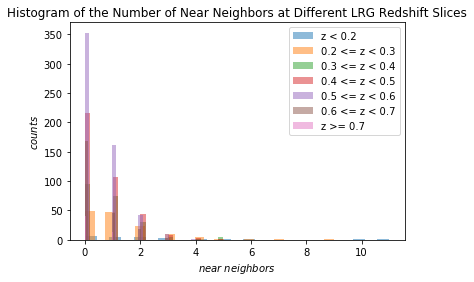

In [36]:
# Plot distribution of nn in different LRG redshift bins

near = np.array(near)
# print("z = ", z)
# print(type(z))

# LRG redshift from 0.0721669 <= z <= 0.846769
# bins of ~0.1

# z < 0.2
near1z = near[np.where(z < 0.2)]
# print(len(Nsat1))

sumnear1z = []
for i in range(len(near1z)):
    sumnear1z.append(np.sum(near1z[i]))

# 0.2 <= z < 0.3
near2z = near[np.where((z >= 0.2) & (0.3 > z))]
# print(len(Nsat2))

sumnear2z = []
for i in range(len(near2z)):
    sumnear2z.append(np.sum(near2z[i]))

# 0.3 <= z < 0.4
near3z = near[np.where((z >= 0.3) & (0.4 > z))]
# print(len(Nsat3))

sumnear3z = []
for i in range(len(near3z)):
    sumnear3z.append(np.sum(near3z[i]))

# 0.4 <= z < 0.5
near4z = near[np.where((z >= 0.4) & (0.5 > z))]
# print(len(Nsat4))

sumnear4z = []
for i in range(len(near4z)):
    sumnear4z.append(np.sum(near4z[i]))

# 0.5 <= z < 0.6
near5z = near[np.where((z >= 0.5) & (0.6 > z))]
# print(len(Nsat5))

sumnear5z = []
for i in range(len(near5z)):
    sumnear5z.append(np.sum(near5z[i]))

# 0.6 <= z < 0.7
near6z = near[np.where((z >= 0.6) & (0.7 > z))]
# print(len(Nsat6))

sumnear6z = []
for i in range(len(near6z)):
    sumnear6z.append(np.sum(near6z[i]))

# z >= 0.7
near7z = near[np.where(z >= 0.7)]
# print(len(Nsat7))

sumnear7z = []
for i in range(len(near7z)):
    sumnear7z.append(np.sum(near7z[i]))
    
    
plt.title("Histogram of the Number of Near Neighbors at Different LRG Redshift Slices")
plt.hist(sumnear1z, bins=25, alpha=0.5, label='z < 0.2')
plt.hist(sumnear2z, bins=25, alpha=0.5, label='0.2 <= z < 0.3')
plt.hist(sumnear3z, bins=25, alpha=0.5, label='0.3 <= z < 0.4')
plt.hist(sumnear4z, bins=25, alpha=0.5, label='0.4 <= z < 0.5')
plt.hist(sumnear5z, bins=25, alpha=0.5, label='0.5 <= z < 0.6')
plt.hist(sumnear6z, bins=25, alpha=0.5, label='0.6 <= z < 0.7')
plt.hist(sumnear7z, bins=25, alpha=0.5, label='z >= 0.7')
plt.xlabel(r'$near$ $neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
# plt.title("Histogram of the Number of Near Neighbors at LRG z < 0.2")
# plt.hist(sumnear1z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.2 <= z < 0.3")
# plt.hist(sumnear2z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.3 <= z < 0.4")
# plt.hist(sumnear3z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.4 <= z < 0.5")
# plt.hist(sumnear4z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.5 <= z < 0.6")
# plt.hist(sumnear5z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.6 <= z < 0.7")
# plt.hist(sumnear6z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG z >= 0.7")
# plt.hist(sumnear7z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()


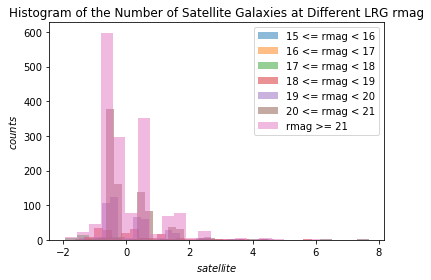

In [37]:
# Plot distribution of Nsat in different LRG rmag bins

rmag_LOWZ = np.array(rmag_LOWZ)
# print("z = ", z)
# print(type(z))

# LRG rmag from 22.3639 <= rmag <= 15.8399
# bins of ~1 mag

# 15 <= rmag < 16
Nsat1r = Nsat[np.where((rmag_LOWZ >= 15.) & (16. > rmag_LOWZ))]
# print(len(Nsat1))

sumsat1r = []
for i in range(len(Nsat1r)):
    sumsat1r.append(np.sum(Nsat1r[i]))

# 16 <= rmag < 17
Nsat2r = Nsat[np.where((rmag_LOWZ >= 16.) & (17. > rmag_LOWZ))]
# print(len(Nsat2))

sumsat2r = []
for i in range(len(Nsat2r)):
    sumsat2r.append(np.sum(Nsat2r[i]))

# 17 <= rmag < 18
Nsat3r = Nsat[np.where((rmag_LOWZ >= 17.) & (18. > rmag_LOWZ))]
# print(len(Nsat3))

sumsat3r = []
for i in range(len(Nsat3r)):
    sumsat3r.append(np.sum(Nsat3r[i]))

# 18 <= rmag < 19
Nsat4r = Nsat[np.where((rmag_LOWZ >= 18.) & (19. > rmag_LOWZ))]
# print(len(Nsat4))

sumsat4r = []
for i in range(len(Nsat4r)):
    sumsat4r.append(np.sum(Nsat4r[i]))

# 19 <= rmag < 20
Nsat5r = Nsat[np.where((rmag_LOWZ >= 19.) & (20. > rmag_LOWZ))]
# print(len(Nsat5))

sumsat5r = []
for i in range(len(Nsat5r)):
    sumsat5r.append(np.sum(Nsat5r[i]))

# 20 <= rmag < 21
Nsat6r = Nsat[np.where((rmag_LOWZ >= 20.) & (21. > rmag_LOWZ))]
# print(len(Nsat6))

sumsat6r = []
for i in range(len(Nsat6r)):
    sumsat6r.append(np.sum(Nsat6r[i]))

# rmag >= 21
Nsat7r = Nsat[np.where(rmag_LOWZ >= 0.7)]
# print(len(Nsat7))

sumsat7r = []
for i in range(len(Nsat7r)):
    sumsat7r.append(np.sum(Nsat7r[i]))
    

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG rmag")
plt.hist(sumsat1r, bins=25, alpha=0.5, label='15 <= rmag < 16')
plt.hist(sumsat2r, bins=25, alpha=0.5, label='16 <= rmag < 17')
plt.hist(sumsat3r, bins=25, alpha=0.5, label='17 <= rmag < 18')
plt.hist(sumsat4r, bins=25, alpha=0.5, label='18 <= rmag < 19')
plt.hist(sumsat5r, bins=25, alpha=0.5, label='19 <= rmag < 20')
plt.hist(sumsat6r, bins=25, alpha=0.5, label='20 <= rmag < 21')
plt.hist(sumsat7r, bins=25, alpha=0.5, label='rmag >= 21')
plt.xlabel(r'$satellite$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
# plt.title("Histogram of the Number of Satellite Galaxies at LRG 15 <= rmag < 16")
# plt.hist(sumsat1r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 16 <= rmag < 17")
# plt.hist(sumsat2r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG  17 <= rmag < 18")
# plt.hist(sumsat3r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 18 <= rmag < 19")
# plt.hist(sumsat4r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 19 <= rmag < 20")
# plt.hist(sumsat5r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 20 <= rmag < 21")
# plt.hist(sumsat6r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG rmag >= 21")
# plt.hist(sumsat7r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()


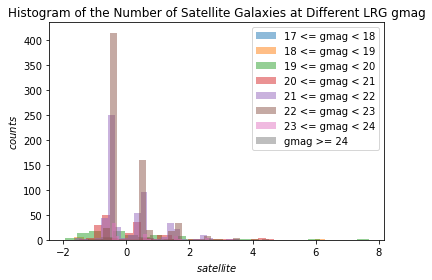

In [39]:
# Plot distribution of Nsat in different LRG gmag bins

gmag_LOWZ = np.array(gmag_LOWZ)
# print("z = ", z)
# print(type(z))

# LRG gmag from 25.1832 <= rmag <= 17.0737
# bins of ~1 mag

# 17 <= gmag < 18
Nsat1g = Nsat[np.where((gmag_LOWZ >= 17.) & (18. > gmag_LOWZ))]
# print(len(Nsat1))

sumsat1g = []
for i in range(len(Nsat1g)):
    sumsat1g.append(np.sum(Nsat1g[i]))

# 18 <= gmag < 19
Nsat2g = Nsat[np.where((gmag_LOWZ >= 18.) & (19. > gmag_LOWZ))]
# print(len(Nsat2))

sumsat2g = []
for i in range(len(Nsat2g)):
    sumsat2g.append(np.sum(Nsat2g[i]))

# 19 <= gmag < 20
Nsat3g = Nsat[np.where((gmag_LOWZ >= 19.) & (20. > gmag_LOWZ))]
# print(len(Nsat3))

sumsat3g = []
for i in range(len(Nsat3g)):
    sumsat3g.append(np.sum(Nsat3g[i]))

# 20 <= gmag < 21
Nsat4g = Nsat[np.where((gmag_LOWZ >= 20.) & (21. > gmag_LOWZ))]
# print(len(Nsat4))

sumsat4g = []
for i in range(len(Nsat4g)):
    sumsat4g.append(np.sum(Nsat4g[i]))

# 21 <= gmag < 22
Nsat5g = Nsat[np.where((gmag_LOWZ >= 21.) & (22. > gmag_LOWZ))]
# print(len(Nsat5))

sumsat5g = []
for i in range(len(Nsat5g)):
    sumsat5g.append(np.sum(Nsat5g[i]))

# 22 <= gmag < 23
Nsat6g = Nsat[np.where((gmag_LOWZ >= 22.) & (23. > gmag_LOWZ))]
# print(len(Nsat6))

sumsat6g = []
for i in range(len(Nsat6g)):
    sumsat6g.append(np.sum(Nsat6g[i]))
    
# 23 <= gmag < 24
Nsat7g = Nsat[np.where((gmag_LOWZ >= 23.) & (24. > gmag_LOWZ))]
# print(len(Nsat7))

sumsat7g = []
for i in range(len(Nsat7g)):
    sumsat7g.append(np.sum(Nsat7g[i]))

# gmag >= 24
Nsat8g = Nsat[np.where(gmag_LOWZ >= 24)]
# print(len(Nsat8))

sumsat8g = []
for i in range(len(Nsat8g)):
    sumsat8g.append(np.sum(Nsat8g[i]))
    

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG gmag")
plt.hist(sumsat1g, bins=25, alpha=0.5, label='17 <= gmag < 18')
plt.hist(sumsat2g, bins=25, alpha=0.5, label='18 <= gmag < 19')
plt.hist(sumsat3g, bins=25, alpha=0.5, label='19 <= gmag < 20')
plt.hist(sumsat4g, bins=25, alpha=0.5, label='20 <= gmag < 21')
plt.hist(sumsat5g, bins=25, alpha=0.5, label='21 <= gmag < 22')
plt.hist(sumsat6g, bins=25, alpha=0.5, label='22 <= gmag < 23')
plt.hist(sumsat7g, bins=25, alpha=0.5, label='23 <= gmag < 24')
plt.hist(sumsat8g, bins=25, alpha=0.5, label='gmag >= 24')
plt.xlabel(r'$satellite$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 17 <= gmag < 18")
# plt.hist(sumsat1g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 18 <= gmag < 19")
# plt.hist(sumsat2g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG  19 <= gmag < 20")
# plt.hist(sumsat3g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 20 <= gmag < 21")
# plt.hist(sumsat4g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 21 <= gmag < 22")
# plt.hist(sumsat5g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 22 <= gmag < 23")
# plt.hist(sumsat6g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 23 <= gmag < 24")
# plt.hist(sumsat7g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG gmag >= 24")
# plt.hist(sumsat8g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()


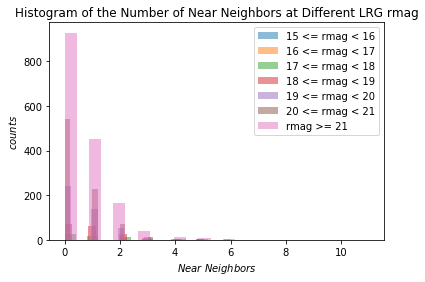

In [40]:
# Plot distribution of nn in different LRG rmag bins

rmag_LOWZ = np.array(rmag_LOWZ)
# print("z = ", z)
# print(type(z))

# LRG rmag from 22.3639 <= rmag <= 15.8399
# bins of ~1 mag

# 15 <= rmag < 16
near1r = near[np.where((rmag_LOWZ >= 15.) & (16. > rmag_LOWZ))]
# print(len(Nsat1))

sumnear1r = []
for i in range(len(near1r)):
    sumnear1r.append(np.sum(near1r[i]))

# 16 <= rmag < 17
near2r = near[np.where((rmag_LOWZ >= 16.) & (17. > rmag_LOWZ))]
# print(len(Nsat2))

sumnear2r = []
for i in range(len(near2r)):
    sumnear2r.append(np.sum(near2r[i]))

# 17 <= rmag < 18
near3r = near[np.where((rmag_LOWZ >= 17.) & (18. > rmag_LOWZ))]
# print(len(Nsat3))

sumnear3r = []
for i in range(len(near3r)):
    sumnear3r.append(np.sum(near3r[i]))

# 18 <= rmag < 19
near4r = near[np.where((rmag_LOWZ >= 18.) & (19. > rmag_LOWZ))]
# print(len(Nsat4))

sumnear4r = []
for i in range(len(near4r)):
    sumnear4r.append(np.sum(near4r[i]))

# 19 <= rmag < 20
near5r = near[np.where((rmag_LOWZ >= 19.) & (20. > rmag_LOWZ))]
# print(len(Nsat5))

sumnear5r = []
for i in range(len(near5r)):
    sumnear5r.append(np.sum(near5r[i]))

# 20 <= rmag < 21
near6r = near[np.where((rmag_LOWZ >= 20.) & (21. > rmag_LOWZ))]
# print(len(Nsat6))

sumnear6r = []
for i in range(len(near6r)):
    sumnear6r.append(np.sum(near6r[i]))

# rmag >= 21
near7r = near[np.where(rmag_LOWZ >= 0.7)]
# print(len(Nsat7))

sumnear7r = []
for i in range(len(near7r)):
    sumnear7r.append(np.sum(near7r[i]))
    
    
plt.title("Histogram of the Number of Near Neighbors at Different LRG rmag")
plt.hist(sumnear1r, bins=25, alpha=0.5, label='15 <= rmag < 16')
plt.hist(sumnear2r, bins=25, alpha=0.5, label='16 <= rmag < 17')
plt.hist(sumnear3r, bins=25, alpha=0.5, label='17 <= rmag < 18')
plt.hist(sumnear4r, bins=25, alpha=0.5, label='18 <= rmag < 19')
plt.hist(sumnear5r, bins=25, alpha=0.5, label='19 <= rmag < 20')
plt.hist(sumnear6r, bins=25, alpha=0.5, label='20 <= rmag < 21')
plt.hist(sumnear7r, bins=25, alpha=0.5, label='rmag >= 21')
plt.xlabel(r'$Near$ $Neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
    
# plt.title("Histogram of the Number of Near Neighbors at LRG 15 <= rmag < 16")
# plt.hist(sumnear1r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 16 <= rmag < 17")
# plt.hist(sumnear2r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG  17 <= rmag < 18")
# plt.hist(sumnear3r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 18 <= rmag < 19")
# plt.hist(sumnear4r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 19 <= rmag < 20")
# plt.hist(sumnear5r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 20 <= rmag < 21")
# plt.hist(sumnear6r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG rmag >= 21")
# plt.hist(sumnear7r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()


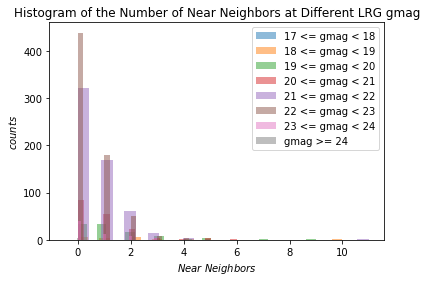

In [41]:
# Plot distribution of nn in different LRG gmag bins

gmag_LOWZ = np.array(gmag_LOWZ)
# print("z = ", z)
# print(type(z))

# LRG gmag from 25.1832 <= rmag <= 17.0737
# bins of ~1 mag

# 17 <= gmag < 18
near1g = near[np.where((gmag_LOWZ >= 17.) & (18. > gmag_LOWZ))]
# print(len(Nsat1))

sumnear1g = []
for i in range(len(near1g)):
    sumnear1g.append(np.sum(near1g[i]))

# 18 <= gmag < 19
near2g = near[np.where((gmag_LOWZ >= 18.) & (19. > gmag_LOWZ))]
# print(len(near2g))

sumnear2g = []
for i in range(len(near2g)):
    sumnear2g.append(np.sum(near2g[i]))
# print(len(sumnear2g))
    
# 19 <= gmag < 20
near3g = near[np.where((gmag_LOWZ >= 19.) & (20. > gmag_LOWZ))]
# print(len(Nsat3))

sumnear3g = []
for i in range(len(near3g)):
    sumnear3g.append(np.sum(near3g[i]))

# 20 <= gmag < 21
near4g = near[np.where((gmag_LOWZ >= 20.) & (21. > gmag_LOWZ))]
# print(len(Nsat4))

sumnear4g = []
for i in range(len(near4g)):
    sumnear4g.append(np.sum(near4g[i]))

# 21 <= gmag < 22
near5g = near[np.where((gmag_LOWZ >= 21.) & (22. > gmag_LOWZ))]
# print(len(Nsat5))

sumnear5g = []
for i in range(len(near5g)):
    sumnear5g.append(np.sum(near5g[i]))

# 22 <= gmag < 23
near6g = near[np.where((gmag_LOWZ >= 22.) & (23. > gmag_LOWZ))]
# print(len(Nsat6))

sumnear6g = []
for i in range(len(near6g)):
    sumnear6g.append(np.sum(near6g[i]))
    
# 23 <= gmag < 24
near7g = near[np.where((gmag_LOWZ >= 23.) & (24. > gmag_LOWZ))]
# print(len(Nsat7))

sumnear7g = []
for i in range(len(near7g)):
    sumnear7g.append(np.sum(near7g[i]))

# gmag >= 24
near8g = near[np.where(gmag_LOWZ >= 24)]
# print(len(Nsat8))

sumnear8g = []
for i in range(len(near8g)):
    sumnear8g.append(np.sum(near8g[i]))
    

plt.title("Histogram of the Number of Near Neighbors at Different LRG gmag")
plt.hist(sumnear1g, bins=25, alpha=0.5, label='17 <= gmag < 18')
plt.hist(sumnear2g, bins=25, alpha=0.5, label='18 <= gmag < 19')
plt.hist(sumnear3g, bins=25, alpha=0.5, label='19 <= gmag < 20')
plt.hist(sumnear4g, bins=25, alpha=0.5, label='20 <= gmag < 21')
plt.hist(sumnear5g, bins=25, alpha=0.5, label='21 <= gmag < 22')
plt.hist(sumnear6g, bins=25, alpha=0.5, label='22 <= gmag < 23')
plt.hist(sumnear7g, bins=25, alpha=0.5, label='23 <= gmag < 24')
plt.hist(sumnear8g, bins=25, alpha=0.5, label='gmag >= 24')
plt.xlabel(r'$Near$ $Neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
    
# plt.title("Histogram of the Number of Near Neighbors at LRG 17 <= gmag < 18")
# plt.hist(sumnear1g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 18 <= gmag < 19")
# plt.hist(sumnear2g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG  19 <= gmag < 20")
# plt.hist(sumnear3g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 20 <= gmag < 21")
# plt.hist(sumnear4g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 21 <= gmag < 22")
# plt.hist(sumnear5g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 22 <= gmag < 23")
# plt.hist(sumnear6g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 23 <= gmag < 24")
# plt.hist(sumnear7g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG gmag >= 24")
# plt.hist(sumnear8g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()




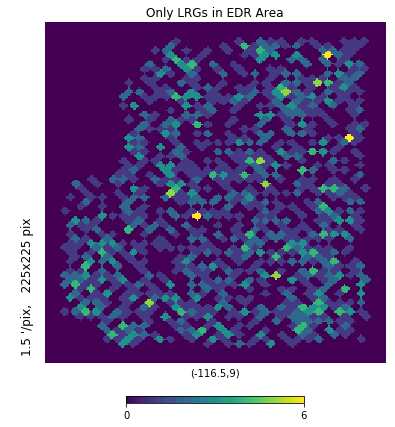

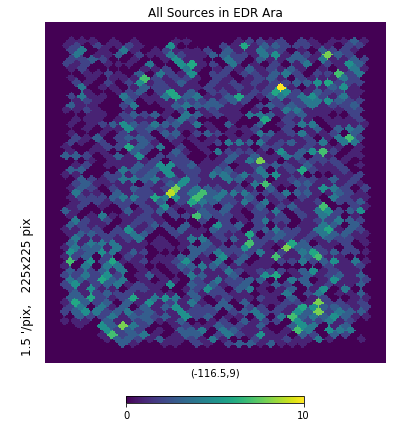

In [54]:
# Use HEALPix/Healpy to plot of sources over the sky

# add flip='geo' to make it look like the RA-Dec plot

%matplotlib inline

theta, phi = np.radians(90-dec_LOWZ), np.radians(ra_LOWZ)
nside = 512
npixel= hp.nside2npix(nside)
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_,rot=(-116.5,9.),xsize=225,title="Only LRGs in EDR Area")

ra = np.concatenate([ra_LOWZ, ra_no_LOWZ])
dec = np.concatenate([dec_LOWZ, dec_no_LOWZ])

theta, phi = np.radians(90-dec), np.radians(ra)
nside = 512
npixel= hp.nside2npix(nside)
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_,rot=(-116.5,9.),xsize=225,title="All Sources in EDR Ara")